In [1]:
# compare the F-corrfunc code, with the results average from 8 realizations,
# to Linear theory

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from hankel import HankelTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path = '/Users/ngoc/Desktop/Master-study/project'

In [2]:
#cosmological parameters
f        = 0.687255861
b        = 3.11                                 # bias for halo b = \delta_halo/\delta_matter
beta     = f/b
z        = 0.306                                #redshift
H_0      = 67                                   #Hubble const
Omg_lamb = 0.685                                #cosmological density parameter
Omg_m    = 1 - Omg_lamb                         #mater density parameter
a        = 1/(1 + z)                            #scale factor
E_a      = np.sqrt(Omg_m*(1+z)**3 + Omg_lamb)   #parameter of Hubble H = E(a)*H_0


In [3]:
#simulation parameters
boxsize  = 2000            #length of 1D of the box [Mpc/h]
nthreads = 4               #number of Open MP threads to use 
autocorr = 1               #auto correlation
nbins    = 50             #number of bins
rmin     = 1.
rmax     = boxsize/3
kmin     = 2*np.pi/rmax
bins     = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)  
#bins     = np.linspace(rmin, rmax, nbins+1)  
mu_max   = 1               #maximum value of cosine of the angle separated from the LOS
nmu_bins = 10              #number of bins of the angle separation 
delta_mu = mu_max/nmu_bins


In [4]:
#Legendre polynomials
P0 = 1
P_2 = lambda mu: (3*mu**2  - 1)/2
P_4 = lambda mu: (35*mu**4 - 30*mu**2 + 3)/8  

Results for all 8 realizations and average of them,
calculating time  1988.3836790000000 seconds ~ 33 mins

In [6]:
ndata    = 8                       #number of realizations
realizations = "12345678"         #for reading the data
A_0 = np.zeros((ndata,nbins))
r   = np.zeros((ndata,nbins))
A_2 = np.zeros((ndata,nbins))
A_4 = np.zeros((ndata,nbins))

In [10]:
for i in range (0,ndata):

    #load results for 8 realization
    DDsmu_f = np.loadtxt(path+'/my-f-code/results/xi-ddsmu-realization'+realizations[i]+'.txt', usecols = (0))
    rsmu_f  = np.loadtxt(path+'/my-f-code/results/xi-ddsmu-realization'+realizations[i]+'.txt', usecols = (1))
    mu_f    = np.loadtxt(path+'/my-f-code/results/xi-ddsmu-realization'+realizations[i]+'.txt', usecols = (2))
    
    X = np.loadtxt(path+'/catalogs/1'+realizations[i]+'/gals/2gpc/R11'+realizations[i]+'_S014_clu_d.cat', usecols = (1))
   
    N  = len(X)                   #number of halos
    V  = 4/3*np.pi*(bins[1::]**3 - bins[0:-1:]**3)
    RR = V*N*(N-1)/boxsize**3

    #monopole      
    xi0_f = np.zeros(nbins)
    r0_f  = np.zeros(nbins)

    l = 0 
    for ii in range(0,nbins):
        RR_mu = RR[ii]/nmu_bins
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        
            xi0_f[ii] += (DDsmu_f[j]/RR_mu-1)*P0*delta_mu   
            r0_f[ii]  += rsmu_f[j]
        
    r0_f /= nmu_bins
    
    A_0[i] = xi0_f
    r[i]   = r0_f    
    
    #quadrupole
    xi2_f = np.zeros(nbins)

    l = 2 
    for ii in range(0,nbins):
        RR_mu = RR[ii]/nmu_bins
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi2_f[ii] += (DDsmu_f[j]/RR_mu-1)*delta_mu*P_2(mu_f[j])

    xi2_f *= (2*l+1)
    A_2[i] = xi2_f
    
    #hexadecapole
    xi4_f = np.zeros(nbins)

    l = 4 
    for ii in range(0,nbins):
        RR_mu = RR[ii]/nmu_bins
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi4_f[ii] += (DDsmu_f[j]/RR_mu-1)*delta_mu*P_4(mu_f[j])
       
    xi4_f *= (2*l+1)
    A_4[i] = xi4_f
    
    

In [11]:
# calculate the average of 8 realizations and error bars

#monopole
xi_dd0_s = np.zeros(nbins)
r_s      = np.zeros(nbins)

for i in range(0,nbins):
    r_s[i]      = np.mean(r[0:ndata,i])
    xi_dd0_s[i] = np.mean(A_0[0:ndata,i])


error_xi_dd0_s = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_0[j,i] - xi_dd0_s[i])**2.
    error_xi_dd0_s[i] = np.sqrt(a/(ndata-1)) #standard deviation
serror_xi_dd0_s = error_xi_dd0_s/np.sqrt(ndata)

#quadrupole
xi_dd2_s = np.zeros(nbins)
for i in range(0,nbins):
    xi_dd2_s[i] = np.mean(A_2[0:ndata,i])

error_xi_dd2_s = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_2[j,i] - xi_dd2_s[i])**2
    error_xi_dd2_s[i] = np.sqrt(a/(ndata-1))
serror_xi_dd2_s = error_xi_dd2_s/np.sqrt(ndata)


#hexadecapole
xi_dd4_s = np.zeros(nbins)
for i in range(0,nbins):
    xi_dd4_s[i] = np.mean(A_4[0:ndata,i])

error_xi_dd4_s = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_4[j,i] - xi_dd4_s[i])**2
    error_xi_dd4_s[i] = np.sqrt(a/(ndata))
serror_xi_dd4_s = error_xi_dd4_s/np.sqrt(ndata-1)




In [12]:

A0  = 1 + 2/3*beta + 1/5*beta**2
A2  = 4/3*beta + 4/7*beta**2
A4  = 8/35*beta**2

k   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (0))
P   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (1))
r   = r_s
P_k = spline(k, P)

#monopole
h0  = HankelTransform(nu = 1/2, N = 3000, h = 1e-5)
f_0 = lambda k: P_k(k)*np.sqrt(k)/(np.pi*2)**(3/2)
xi_dd0_r = 1/np.sqrt(r)*h0.transform(f_0,r, ret_err=False, inverse=True)*A0*b**2

#quadrupole
h2  = HankelTransform(nu = 5/2, N = 3000, h = 1e-5)
f_2 = lambda k: P_k(k)*np.sqrt(k)/(np.pi*2)**(3/2)
xi_dd2_r = -1/np.sqrt(r)*h2.transform(f_2,r, ret_err=False, inverse=True)*A2*b**2    
 
#hexadecapole
h4  = HankelTransform(nu = 9/2, N = 3000, h = 1e-5)
f_4 = lambda k: P_k(k)*np.sqrt(k)/(np.pi*2)**(3/2)
xi_dd4_r = 1/np.sqrt(r)*h4.transform(f_4,r, ret_err=False, inverse=True)*A4*b**2
        

(-100.0, 350.0)

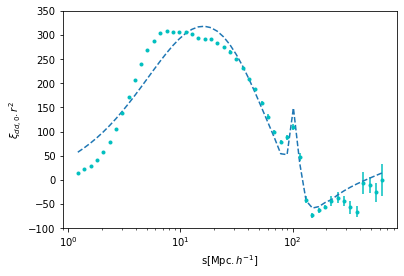

In [17]:
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.errorbar(r, xi_dd0_s*r**2, fmt ='c.',yerr = serror_xi_dd0_s*r**2 ,label="F-avg")
ax.plot(r, xi_dd0_r*r**2, '--',label="Linear")
ax.set_ylabel("$\\xi_{dd,0}.r^2$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
#ax.set_xlim(1,100)
ax.set_ylim(-100,350)
#ax.legend()
#plt.savefig('Fmono.png')

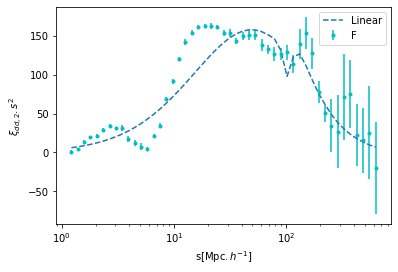

In [20]:
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.errorbar(r,  -xi_dd2_s*r**2, fmt ='c.', yerr = serror_xi_dd2_s*r**2 , label="F")
ax.plot(r,  -xi_dd2_r*r**2, '--', label="Linear")

ax.set_ylabel("$\\xi_{dd,2}.s^2$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
ax.legend()
#ax.set_xlim(10,)
#ax.set_ylim(-300,500)
#plt.savefig('Fquad.png')
#plt.savefig


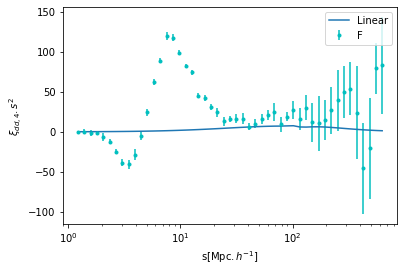

In [21]:
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.errorbar(r,  xi_dd4_s*r**2, fmt ='c.',yerr = serror_xi_dd4_s*r**2 , label="F")
ax.plot(r,  xi_dd4_r*r**2, '-', label="Linear")

ax.set_ylabel("$\\xi_{dd,4}.s^2$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
ax.legend()
#ax.set_xlim(10,)
#ax.set_ylim(-300,500)
#plt.savefig('Fhexa.png')


save results